In [689]:
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)
import Dataloader as _D
reload(_D)

<module 'Dataloader' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\Dataloader.py'>

In [690]:
PORTFOLIO_v0 = list(_C.commodities.keys())
PORTFOLIO_v1 = ['rb', 'hc', 'i', 'm', 'bu', 'SA']
PORTFOLIO_v2 = ['rb', 'hc', 'MA', 'l', 'p', 'v', 'CF']
PORTFOLIO_v3 = ['rb']

In [683]:
PORTFOLIO = PORTFOLIO_v0

### Pnl

In [684]:
tmp = np.load(f'output/balance_sheet/{_C.VERSION}/rb_balance.npy', allow_pickle=True)
VTD = tmp['buy_balance'].index
F_D = _D.Dataset('D', _C.BACKTEST_START, _C.BACKTEST_END)

Using Local D     Data | Local VTD: 2010-01-04--2022-08-19, BackTest VTD: 2010-01-04--2022-08-19


In [685]:
Pnl = {}
total_d_gain_buy = pd.Series([])
total_d_gain_buy = total_d_gain_buy.reindex(VTD).fillna(0)
total_d_gain_sell = pd.Series([])
total_d_gain_sell = total_d_gain_sell.reindex(VTD).fillna(0)
total_d_gain_all = pd.Series([])
total_d_gain_all = total_d_gain_all.reindex(VTD).fillna(0)

# for com in _D.commodities.keys():
for com in list(PORTFOLIO):
    com_balance_dict = np.load(f'output/balance_sheet/{_C.VERSION}/{com}_balance.npy', allow_pickle=True)
    Pnl[com] = com_balance_dict
    if com in PORTFOLIO:
        total_d_gain_buy += com_balance_dict['buy_balance']['d_gain']
        total_d_gain_sell += com_balance_dict['sell_balance']['d_gain']
        total_d_gain_all += com_balance_dict['all_balance']['d_gain']

portfolio_pnl_buy = 1 + total_d_gain_buy.cumsum()/(len(PORTFOLIO) * _C.INIT_CAP)
portfolio_pnl_sell = 1 + total_d_gain_sell.cumsum()/(len(PORTFOLIO) * _C.INIT_CAP)
portfolio_pnl_all = 1 + total_d_gain_all.cumsum()/(len(PORTFOLIO) * _C.INIT_CAP)
Pnl['portfolio'] = {'buy_balance': portfolio_pnl_buy, 'sell_balance': portfolio_pnl_sell, 'all_balance': portfolio_pnl_all}

In [686]:
def draw_pnl(scom):
    if scom == 'portfolio':
        fig, axes = plt.subplots(figsize=(10, 4), dpi=100)
        axes.set_title(f'{scom} Pnl', fontsize=8)
        Pnl[scom]['buy_balance'].plot(label='buy pnl', color='green', alpha=0.7, linewidth=0.7)
        Pnl[scom]['sell_balance'].plot(label='sell pnl', color='pink', linewidth=0.7)
        Pnl[scom]['all_balance'].plot(label='all pnl', color='blue', linewidth=0.7)
        axes.legend(fontsize=7)
    else:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), dpi=200, sharex=True)
        axes[0].tick_params(labelsize=7)
        axes[1].tick_params(labelsize=7)

        axes[0].set_title(f'{scom} Daily Price', fontsize=8)
        d_data = F_D[scom].reindex(VTD)
        d_data['EMA_S'] = d_data['CLOSE'].ewm(span=_C.DAY_EMA_S, adjust=False).mean()
        d_data['EMA_L'] = d_data['CLOSE'].ewm(span=_C.DAY_EMA_L, adjust=False).mean()

        d_data = _U.price_adj(d_data, _C.PADJ)
        d_data['CLOSE'].plot(color='b', linewidth=0.7, ax=axes[0])
        d_data['EMA_S'].plot(color='g', linewidth=0.7, ax=axes[0])
        d_data['EMA_L'].plot(color='orange', linewidth=0.7, ax=axes[0])
        axes[0].legend(fontsize=7)

        axes[1].set_title(f'{scom} Pnl', fontsize=8)
        Pnl[scom]['buy_balance']['Pnl'].plot(label='buy pnl', color='green', alpha=0.7, linewidth=0.7, ax=axes[1])
        Pnl[scom]['sell_balance']['Pnl'].plot(label='sell pnl', color='pink', linewidth=0.7, ax=axes[1])
        Pnl[scom]['all_balance']['Pnl'].plot(label='all pnl', color='blue', linewidth=0.7, ax=axes[1])
        axes[1].legend(fontsize=7)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

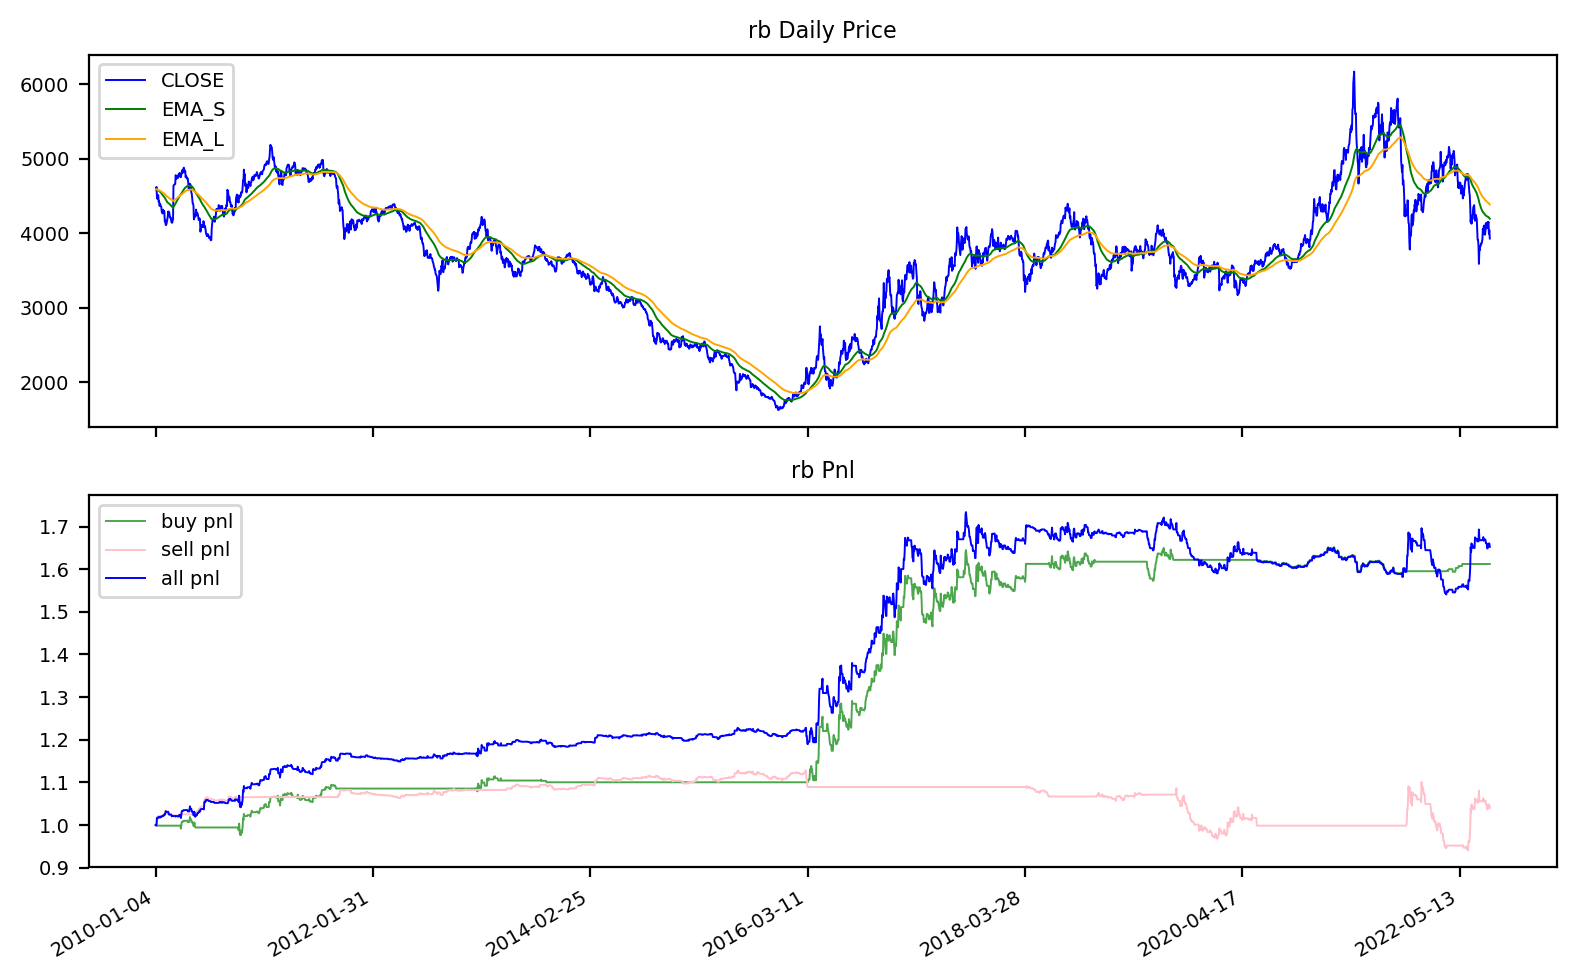

In [687]:
draw_pnl('rb')

In [106]:
with open(f'./output/v_analysis/{_C.VERSION}/Pnl.pkl', 'wb') as f:
    pickle.dump(Pnl, f)

In [392]:
def profitable_analysis(_pnl):
    report = pd.DataFrame(columns=['Annual Return', 'Std', 'Sharpe', 'MaxDrawdown', 'Calmar'])
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - list(_pnl)/pd.Series(list(_pnl.rolling(len(_pnl)))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    report.loc[report.shape[0]] = [Annual_r, Std, Sharpe, MaxDrawdown, Calmar]
    return report

In [393]:
profitable_analysis(Pnl['portfolio'])

,Annual Return,Std,Sharpe,MaxDrawdown,Calmar
0,0.039895,0.053548,0.745031,0.141984,0.280984


### Win-Loss

In [394]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

for com in _C.commodities.keys():
    com_log = np.load(f'output/trading_logs/{_C.VERSION}/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

    if com in PORTFOLIO:
        all_buy = all_buy.append(com_log[0])
        all_sell = all_sell.append(com_log[1])
        all_total = all_total.append(com_log[2])

trading_logs['portfolio'] = [all_buy, all_sell, all_total]

In [396]:
def cal_win_rate(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].shape[0] / _df_['gain'].shape[0], 4)

def cal_win_loss_ratio(_df_):
    return round(_df_['gain'].loc[_df_['gain']>0].sum() / _df_['gain'].loc[_df_['gain']<0].sum() * -1, 4)

In [397]:
cols = ['BUY_wr', 'SELL_wr', 'TOTAL_wr', 'BUY_wlr', 'SELL_wlr', 'TOTAL_wlr']
symbols = list(_D.commodities.keys())+['portfolio']

In [398]:
Win_Loss_Analysis = pd.DataFrame(columns=symbols)
WLA = Win_Loss_Analysis.reindex(cols).transpose()

In [399]:
for com in symbols:
    buy_log = trading_logs[com][0]
    sell_log= trading_logs[com][1]
    total_log = trading_logs[com][2]

    WLA['BUY_wr'][com] = cal_win_rate(buy_log)
    WLA['SELL_wr'][com] = cal_win_rate(sell_log)
    WLA['TOTAL_wr'][com] = cal_win_rate(total_log)

    WLA['BUY_wlr'][com] = cal_win_loss_ratio(buy_log)
    WLA['SELL_wlr'][com] = cal_win_loss_ratio(sell_log)
    WLA['TOTAL_wlr'][com] = cal_win_loss_ratio(total_log)

In [400]:
WLA

,BUY_wr,SELL_wr,TOTAL_wr,BUY_wlr,SELL_wlr,TOTAL_wlr
rb,0.3363,0.3223,0.3229,1.1129,1.1118,1.1003
hc,0.3483,0.3173,0.33,1.0691,1.0683,1.0883
i,0.3158,0.3191,0.3181,1.0564,1.1932,1.1498
m,0.337,0.3202,0.3234,1.051,1.0234,1.0501
pp,0.3264,0.3412,0.333,0.9225,1.0691,0.9998
MA,0.3266,0.2952,0.3105,1.0241,0.8881,0.9521
bu,0.3038,0.3194,0.3116,0.9834,1.0151,1.0285
l,0.3163,0.3149,0.3113,0.9312,1.0145,0.9666
p,0.3273,0.3052,0.3169,1.0908,1.0299,1.0572
v,0.2923,0.2878,0.2913,0.9594,0.9281,0.9681


In [115]:
WLA.to_csv(f'./output/v_analysis/{_C.VERSION}/Win-Loss.csv')

In [118]:
cc = pd.read_csv('./output/v_analysis/v2/Win-Loss.csv', index_col=0)

### Positions

#### Positions Holding Time

In [401]:
hold_t = {}
all_hold_t = []
all_hold_t = pd.Series(all_hold_t)

for com in _C.commodities.keys():
    _df = trading_logs[com][2].copy(deep=True)

    delta_t = pd.to_datetime(_df['close_date']) - pd.to_datetime(_df['open_date'])
    _df['hold_t'] = (delta_t).apply(lambda x: x.total_seconds()/60)

    hold_t[com] = _df['hold_t']
    if com in PORTFOLIO:
        all_hold_t = all_hold_t.append(_df['hold_t'])

hold_t['portfolio'] = all_hold_t

In [402]:
def hold_t_analysis(scom):
    ht = hold_t[scom]
    print(ht.describe())
    ht.hist(bins=20)

In [403]:
cols_2 = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max']
HTA = pd.DataFrame(columns=symbols)
HTA = HTA.reindex(cols_2).transpose()

In [404]:
for com in symbols:
    ht = hold_t[com]
    des = list(ht.describe())
    for i in cols_2:
        HTA[i][com] = round(int(des[cols_2.index(i)])/60, 1) if cols_2.index(i)>0 else des[cols_2.index(i)]

In [405]:
HTA # Holding Period Time

,count,mean,std,min,25%,50%,75%,max
rb,2648,16.2,29.4,0,0,0,24,336
hc,2224,12.4,26,0,0,0,24,240
i,1905,14.5,27.7,0,0,0,24,336
m,2857,15.4,29.8,0,0,0,24,288
pp,1838,14.9,28.8,0,0,0,24,264
MA,2058,12.5,25.4,0,0,0,24,264
bu,2189,14.5,28.3,0,0,0,24,288
l,2364,17.8,31.9,0,0,0,24,264
p,3061,13.8,27.3,0,0,0,24,288
v,2595,17.2,30.5,0,0,0,24,288


In [134]:
HTA.to_csv(f'./output/v_analysis/{_C.VERSION}/HTA.csv')

#### Daily Trade Num

In [406]:
trade_num = {}
F_data = pd.read_pickle(f'dataset/F_data_{_C.TIME_FRAME}.pkl')
VTD = F_data['VTD']
all_trade_num = pd.Series([0 for i in range(len(VTD))])

for com in _D.commodities.keys():
    tn = [0 for i in range(len(VTD))]
    com_log = trading_logs[com]
    _df = com_log[2].copy(deep=True)

    for i in range(_df.shape[0]):
        entry = _df.iloc[i]
        tn[VTD.index(entry['open_date'])] += 1
        tn[VTD.index(entry['close_date'])] += 1
    
    trade_num[com] = tn
    if com in PORTFOLIO:
        all_trade_num += pd.Series(tn)

trade_num['portfolio'] = all_trade_num.to_list()

In [407]:
DTN = pd.DataFrame()
DTN = DTN.reindex(VTD)

for com in symbols:
    DTN[com] = trade_num[com]

In [408]:
DTN # Daily Trade Num

,rb,hc,i,m,pp,MA,bu,l,p,v,CF,OI,SR,TA,SA,portfolio
2010-01-04,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
2010-01-05,1,0,0,0,0,0,0,0,0,3,1,0,4,2,0,1
2010-01-06,3,0,0,0,0,0,0,4,0,3,0,0,3,0,0,3
2010-01-07,3,0,0,1,0,0,0,2,1,2,1,0,3,2,0,4
2010-01-08,3,0,0,1,0,0,0,0,1,2,4,0,1,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,3,0,4,3,4,3,2,3,3,0,2,1,0,1,2,14
2022-08-16,1,0,0,0,2,3,3,2,3,0,2,2,0,4,1,5
2022-08-17,0,0,0,3,5,2,3,1,6,2,2,1,0,2,5,11
2022-08-18,0,2,2,2,3,0,1,2,2,2,3,1,3,0,4,11


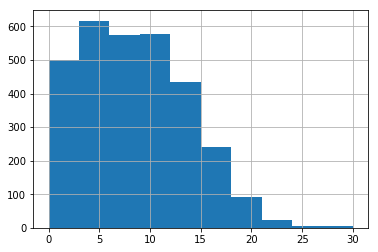

In [409]:
DTN['portfolio'].hist()

In [133]:
DTN.to_csv(f'./output/v_analysis/{_C.VERSION}/DTN.csv')

### Version Comparation

In [35]:
Pnl.keys()

dict_keys(['rb', 'hc', 'i', 'm', 'pp', 'MA', 'bu', 'l', 'p', 'v', 'CF', 'OI', 'SR', 'TA', 'SA', 'total'])

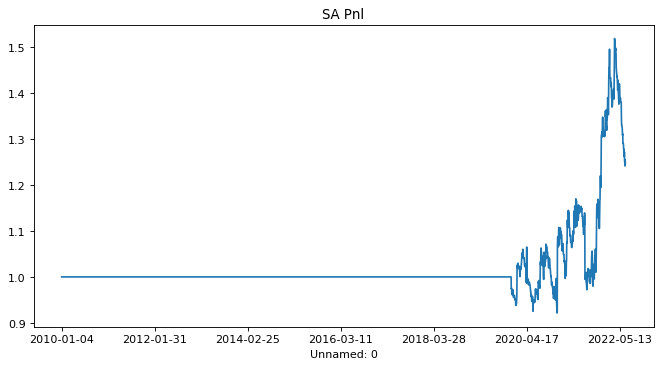

In [50]:
draw_pnl('SA')